INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6
TensorFlow Version: 2.10.1
Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                          

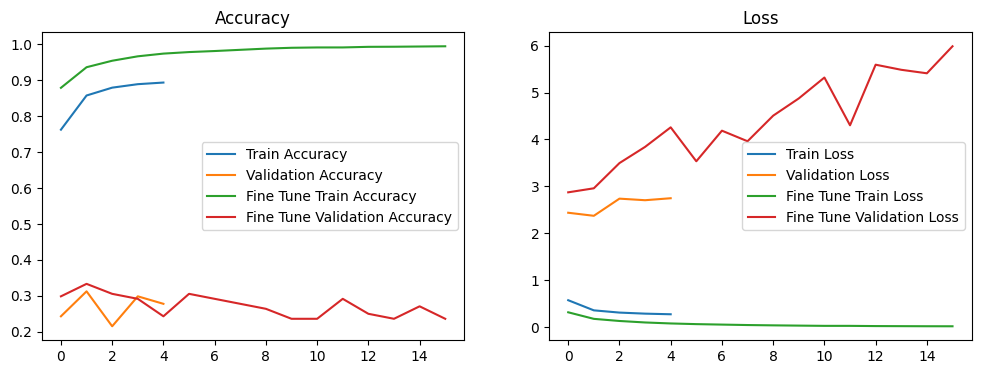

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Enable mixed precision training for performance boost
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Verify GPU is being used
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

# Set GPU device explicitly (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Use the first GPU
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# Model setup
num_classes = 3
BATCH_SIZE = 16
EPOCHS = 10

# Load base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', dtype='float32')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'Test_dataset',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
    ]
)

# Fine-tuning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS + 10,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine Tune Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine Tune Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine Tune Train Loss')
plt.plot(history_fine.history['val_loss'], label='Fine Tune Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


1/1 [==============================] - 2s 2s/step


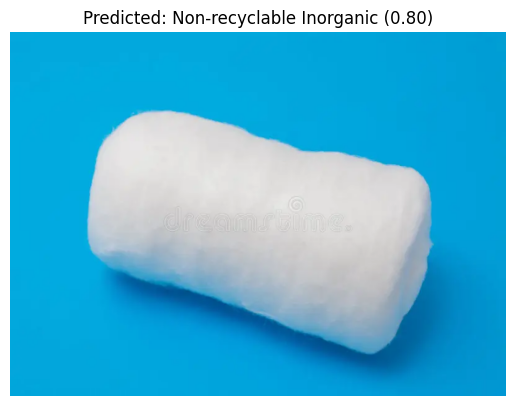

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to a single image for testing
image_path = 'Train/Non-recyclable Inorganic/Cotton/medical-cotton-blue-background-wool-abstract-136903144.jpg'  # Replace with the actual path to your test image

# Load and preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load the image with target size
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale the image
    return img_array

# Make a prediction
def predict_image(model, image_path, class_names):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)  # Predict probabilities
    predicted_class = np.argmax(predictions, axis=1)  # Get class index
    confidence = np.max(predictions)  # Get confidence score
    return predicted_class[0], confidence

# Class names (update these with your actual class names)
class_names = list(train_generator.class_indices.keys())

# Get prediction and confidence
predicted_class, confidence = predict_image(model, image_path, class_names)

# Display the image and the prediction
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f})")
plt.show()


5/5 [==============================] - 1s 93ms/step

Classification Report:
                          precision    recall  f1-score   support

Non-recyclable inorganic       0.47      0.48      0.48        79
    Recyclable inorganic       0.24      0.07      0.11        57
                 organic       0.11      0.38      0.17        16

                accuracy                           0.32       152
               macro avg       0.27      0.31      0.25       152
            weighted avg       0.35      0.32      0.31       152



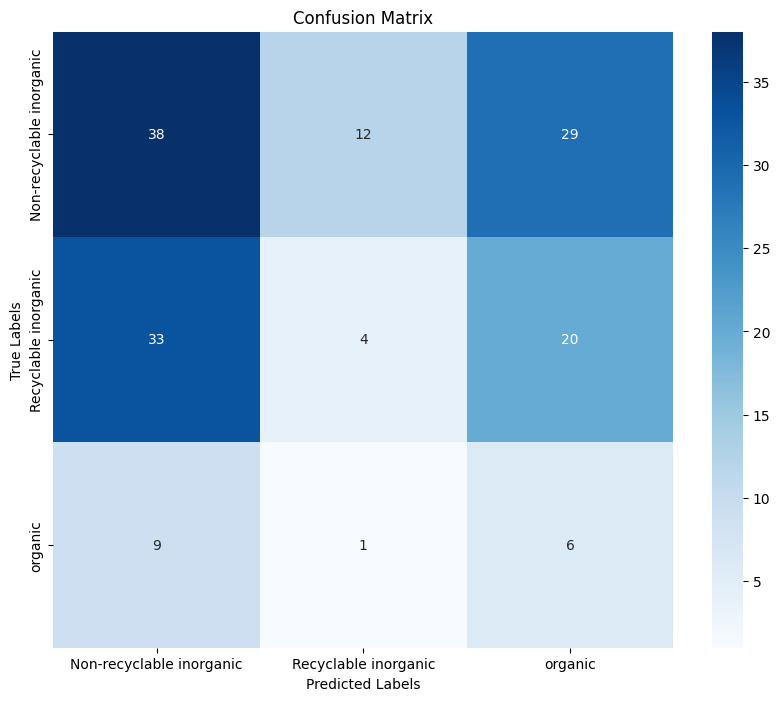

Accuracy: 0.32


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure validation_generator is properly defined
if 'validation_generator' not in globals():
    raise ValueError("The 'validation_generator' is not defined. Ensure it is initialized with your validation dataset.")

# Function to evaluate the model
def evaluate_model(generator, model):
    true_labels = generator.classes  # True labels from the generator
    class_names = list(generator.class_indices.keys())  # Class names

    # Get predictions
    predictions = model.predict(generator)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

    return true_labels, predicted_labels, class_names

# Evaluate the model and get metrics
true_labels, predicted_labels, class_names = evaluate_model(validation_generator, model)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate Accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")


In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("waste.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp4lqi7d1p\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp4lqi7d1p\assets


Num GPUs Available: 1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 27123 images belonging to 3 classes.
Found 6779 images belonging to 3 classes.
Epoch 1/50
1696/1696 [==============================] - 591s 344ms/step - loss: 9.1703 - accuracy: 0.3724 - val_loss: 6.9956 - val_accuracy: 0.4837 - lr: 5.0000e-06
Epoch 2/50
1696/1696 [==============================] - 392s 231ms/step - loss: 8.1721 - accuracy: 0.4503 - val_loss: 6.5454 - val_accuracy: 0.5375 - lr: 1.0000e-05
Epoch 3/50
1696/1696 [==============================] - 394s 232ms/step - loss: 7.2818 - accuracy: 0.5301 - val_loss: 6.1867 - val_accuracy: 0.5757 - lr: 1.5000e-05
Epoch 4/50
1696/1696 [==============================] - 393s 232ms/step - loss: 6.6823 - accuracy: 0.6011 - val_loss: 5.8697 - val_accuracy: 0.6246 - lr: 2.0000e-05
Epoch 5/50
1696/1696 [==============================] - 396s 233ms/step - loss: 6.2046 - accuracy: 0.6561 - val_loss: 5.5763 - val_accuracy: 0.6796 - lr: 2.5

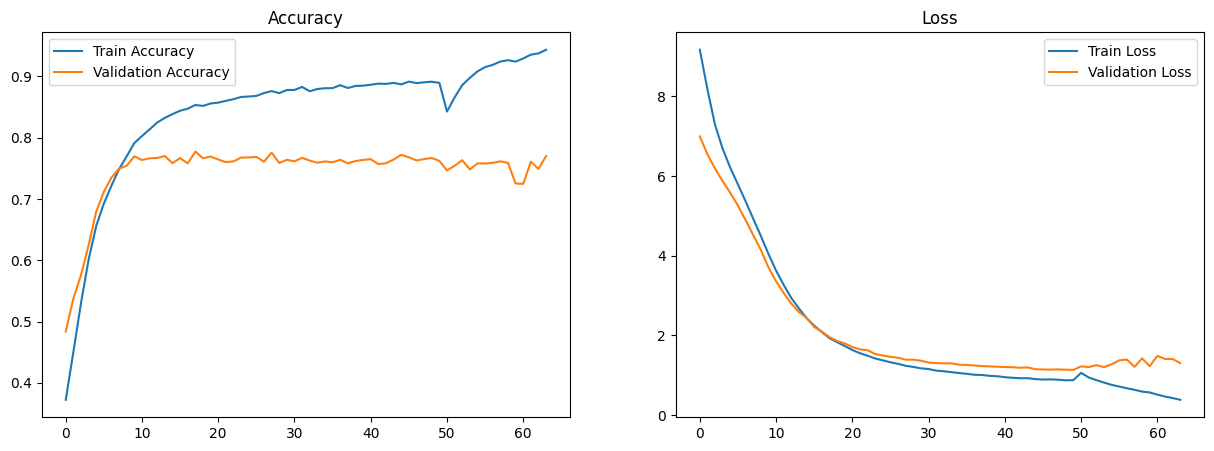

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import ResNet50V2
import matplotlib.pyplot as plt

# GPU Configuration
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

# Model Parameters
num_classes = 3
BATCH_SIZE = 16  # Reduced batch size
EPOCHS = 50      # Reduced epochs
IMG_SIZE = 224

# Enhanced Data Augmentation with more aggressive parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Increased rotation
    width_shift_range=0.3,      # Increased shift
    height_shift_range=0.3,     # Increased shift
    shear_range=0.3,            # Increased shear
    zoom_range=0.3,             # Increased zoom
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3], # Increased brightness range
    fill_mode='nearest',
    validation_split=0.2        # Added validation split
)

# Use the same generator for validation to ensure consistent preprocessing
train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'           # Specify training subset
)

validation_generator = train_datagen.flow_from_directory(
    'Train',                    # Use same directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'         # Specify validation subset
)

# Transfer Learning with ResNet50V2 with L2 regularization
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model layers
base_model.trainable = False

# Added L2 regularization and adjusted architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),              # Increased dropout
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),              # Increased dropout
    Dense(num_classes, activation='softmax')
])

# Modified learning rate schedule with slower decay
initial_learning_rate = 5e-5   # Reduced initial learning rate
def lr_schedule(epoch):
    if epoch < 10:  # Extended warmup
        return initial_learning_rate * ((epoch + 1) / 10)
    else:
        # Slower decay
        return initial_learning_rate * tf.math.exp(0.05 * (10 - epoch))

# Compile with modified optimizer settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=initial_learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modified callbacks for better convergence
callbacks = [
    EarlyStopping(
        monitor='val_loss',     # Changed to monitor loss
        patience=10,            # Reduced patience
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,             # More aggressive LR reduction
        patience=5,
        min_lr=1e-7,
        min_delta=0.001
    ),
    LearningRateScheduler(lr_schedule)
]
class_weights = None
if hasattr(train_generator, 'class_indices'):
    total_samples = train_generator.samples
    class_counts = [0] * num_classes
    for i in range(total_samples):
        class_counts[train_generator.labels[i]] += 1
    max_count = max(class_counts)
    class_weights = {i: max_count/count for i, count in enumerate(class_counts)}

# Initial training phase
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    workers=1,
    use_multiprocessing=False
)

# Modified fine-tuning phase
base_model.trainable = True
# Freeze more layers (increased from 100 to 120)
for layer in base_model.layers[:120]:
    layer.trainable = False

# Recompile with even lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Reduced epochs for fine-tuning
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,                  # Reduced from 30
    callbacks=callbacks,
    class_weight=class_weights,
    workers=1,
    use_multiprocessing=False
)

# Plot Results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], 
         label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], 
         label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], 
         label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], 
         label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


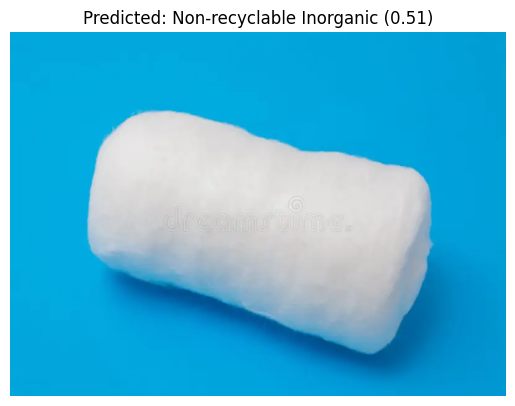

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to a single image for testing
image_path = 'Train/Non-recyclable Inorganic/Cotton/medical-cotton-blue-background-wool-abstract-136903144.jpg'  # Replace with the actual path to your test image

# Load and preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load the image with target size
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale the image
    return img_array

# Make a prediction
def predict_image(model, image_path, class_names):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)  # Predict probabilities
    predicted_class = np.argmax(predictions, axis=1)  # Get class index
    confidence = np.max(predictions)  # Get confidence score
    return predicted_class[0], confidence

# Class names (update these with your actual class names)
class_names = list(train_generator.class_indices.keys())

# Get prediction and confidence
predicted_class, confidence = predict_image(model, image_path, class_names)

# Display the image and the prediction
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f})")
plt.show()


424/424 [==============================] - 77s 179ms/step

Classification Report:
                          precision    recall  f1-score   support

Non-recyclable Inorganic       0.32      0.24      0.27      2224
 Organic Waste Materials       0.09      0.18      0.12       560
    Recyclable Inorganic       0.58      0.59      0.59      3995

                accuracy                           0.44      6779
               macro avg       0.33      0.34      0.33      6779
            weighted avg       0.46      0.44      0.45      6779



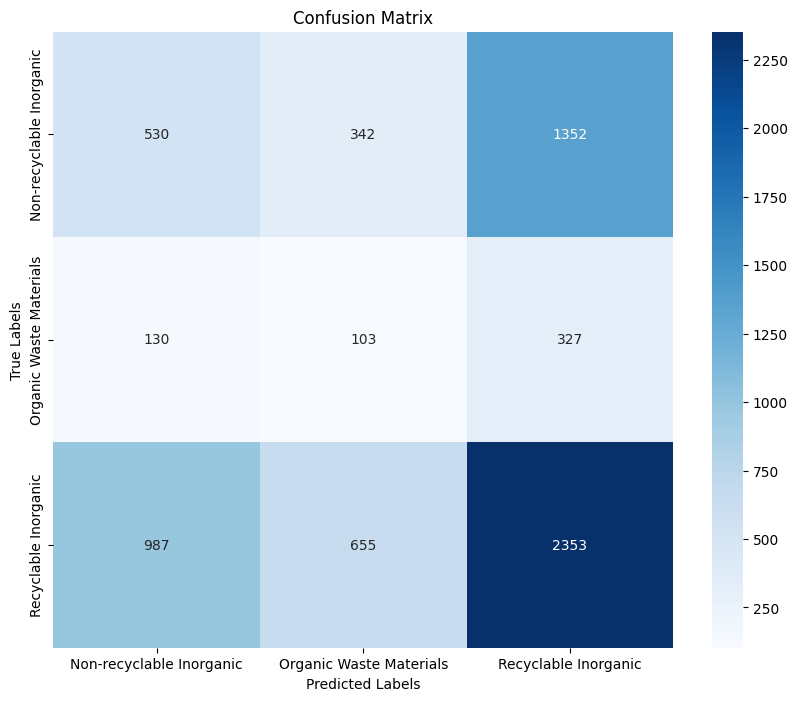

Accuracy: 0.44


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure validation_generator is properly defined
if 'validation_generator' not in globals():
    raise ValueError("The 'validation_generator' is not defined. Ensure it is initialized with your validation dataset.")

# Function to evaluate the model
def evaluate_model(generator, model):
    true_labels = generator.classes  # True labels from the generator
    class_names = list(generator.class_indices.keys())  # Class names

    # Get predictions
    predictions = model.predict(generator)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

    return true_labels, predicted_labels, class_names

# Evaluate the model and get metrics
true_labels, predicted_labels, class_names = evaluate_model(validation_generator, model)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate Accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")


In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D,
    BatchNormalization, Dropout, Concatenate, Add, LeakyReLU,
    SeparableConv2D, Activation, AveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
# For newer TensorFlow versions (2.4+)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_CLASSES = 3
EPOCHS = 100
BASE_LR = 1e-4

# Define custom noise layer for training robustness
class GaussianNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev=0.1):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev
        
    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), 
                                     mean=0.0, 
                                     stddev=self.stddev, 
                                     dtype=inputs.dtype)
            return inputs + noise
        return inputs
    
    def get_config(self):
        config = super().get_config()
        config.update({"stddev": self.stddev})
        return config

# Build custom inception-style module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, 
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0002))(x)
    
    # 3x3 convolution branch
    pre_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0002))(pre_3x3)
    
    # 5x5 convolution branch (using two 3x3 to reduce parameters)
    pre_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5_1 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu')(pre_5x5)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0002))(conv_5x5_1)
    
    # Pooling branch
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool)
    
    # Concatenate all branches
    output = Concatenate()([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

# Residual block with channel attention
def residual_block(x, filters, kernel_size=3, stride=1, use_attention=True):
    shortcut = x
    
    # If dimensions change, adjust shortcut
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    
    # First convolution
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)
    
    # Second convolution
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    
    # Channel attention mechanism
    if use_attention:
        se = GlobalAveragePooling2D()(y)
        se = Dense(filters // 16, activation='relu')(se)
        se = Dense(filters, activation='sigmoid')(se)
        se = tf.reshape(se, [-1, 1, 1, filters])
        y = y * se
    
    # Add shortcut connection
    output = Add()([shortcut, y])
    output = LeakyReLU(0.2)(output)
    
    return output

# Create robust model architecture
def create_robust_model():
    # Input layer
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Initial noise layer for robustness training
    x = GaussianNoiseLayer(stddev=0.05)(inputs)
    
    # Initial convolution block
    x = Conv2D(64, (7, 7), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # First residual block stage
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Second stage with inception module
    x = inception_module(x, 64, 48, 64, 16, 32, 32)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Third stage with residual blocks
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, use_attention=True)
    
    # Multi-scale feature extraction - parallel pathways
    # Path 1: Standard convolution
    path1 = Conv2D(256, (3, 3), padding='same')(x)
    path1 = LeakyReLU(0.1)(path1)
    path1 = BatchNormalization()(path1)
    
    # Path 2: Dilated convolution for larger receptive field
    path2 = Conv2D(256, (3, 3), padding='same', dilation_rate=2)(x)
    path2 = LeakyReLU(0.1)(path2)
    path2 = BatchNormalization()(path2)
    
    # Path 3: Separable convolution for efficiency
    path3 = SeparableConv2D(256, (5, 5), padding='same')(x)
    path3 = LeakyReLU(0.1)(path3)
    path3 = BatchNormalization()(path3)
    
    # Combine paths
    x = Concatenate()([path1, path2, path3])
    x = Conv2D(512, (1, 1), padding='same')(x)  # Bottleneck
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    
    # Global features
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Enhanced data augmentation for robustness
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    # Add noise and color adjustments for robustness
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
)

# Simple rescaling for validation
val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    validation_split=0.2
)

# Load data
train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    'Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Calculate class weights to handle imbalance
class_weights = None
try:
    total_samples = train_generator.samples
    class_counts = [0] * NUM_CLASSES
    for i in range(total_samples):
        class_counts[train_generator.labels[i]] += 1
    
    max_count = max(class_counts)
    class_weights = {i: float(max_count)/float(max(1, count)) for i, count in enumerate(class_counts)}
    print(f"Class weights: {class_weights}")
except Exception as e:
    print(f"Warning: Could not calculate class weights: {e}")
    
# Create model
model = create_robust_model()

# Compile with appropriate settings
optimizer = Adam(learning_rate=BASE_LR)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks for training
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1,
        min_delta=0.005
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Ensure best weights are loaded
# model.load_weights('best_model.h5')

# Function for test-time augmentation (TTA)
def evaluate_with_tta(model, generator, num_tta=10):
    generator.reset()
    n_samples = generator.samples
    probabilities = np.zeros((n_samples, NUM_CLASSES))
    true_labels = np.zeros((n_samples, NUM_CLASSES))
    
    # Track processed samples
    sample_count = 0
    
    # Get true labels
    true_labels_array = generator.classes
    true_labels = tf.keras.utils.to_categorical(true_labels_array, NUM_CLASSES)
    
    # Define augmentations for TTA
    tta_datagen = ImageDataGenerator(
        preprocessing_function=lambda x: x/255.0,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    # Process each batch
    batch_size = generator.batch_size
    steps = int(np.ceil(n_samples / batch_size))
    
    for i in range(steps):
        x_batch, _ = next(generator)
        current_batch_size = x_batch.shape[0]
        
        # Original prediction
        batch_pred = model.predict(x_batch, verbose=0)
        
        # Initialize aggregated predictions
        batch_preds_all = batch_pred
        
        # Apply different augmentations for TTA
        for j in range(num_tta - 1):
            x_aug = tta_datagen.flow(x_batch, batch_size=current_batch_size, shuffle=False).next()
            pred_aug = model.predict(x_aug, verbose=0)
            batch_preds_all = batch_preds_all + pred_aug
            
        # Average predictions from all augmentations
        batch_preds_all = batch_preds_all / num_tta
        
        # Store the predictions
        end_idx = min(sample_count + current_batch_size, n_samples)
        probabilities[sample_count:end_idx] = batch_preds_all
        sample_count = end_idx
        
        if end_idx >= n_samples:
            break
    
    # Calculate metrics
    predicted_classes = np.argmax(probabilities, axis=1)
    true_classes = np.argmax(true_labels, axis=1)
    
    # Accuracy
    accuracy = np.mean(predicted_classes == true_classes)
    
    return accuracy, probabilities, true_labels

# Evaluate with TTA
# print("\nEvaluating with test-time augmentation...")
# tta_accuracy, predictions, true_labels = evaluate_with_tta(model, validation_generator)
# print(f"TTA Validation Accuracy: {tta_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save the final model
# model.save('final_robust_model.h5')
# print("Training complete. Model saved as 'final_robust_model.h5'")

# Function to predict on new images with robustness
def predict_with_robustness(model, image_path, size=IMG_SIZE):
    """Predict a single image with robustness techniques"""
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(size, size))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Create multiple slightly augmented versions
    augmentations = []
    augmentations.append(img_batch)  # Original
    
    # Horizontal flip
    augmentations.append(np.flip(img_batch, axis=2))
    
    # Slight rotation
    from scipy.ndimage import rotate
    augmentations.append(np.expand_dims(rotate(img_array, angle=5, reshape=False), axis=0) / 255.0)
    augmentations.append(np.expand_dims(rotate(img_array, angle=-5, reshape=False), axis=0) / 255.0)
    
    # Make predictions on all augmentations
    all_preds = []
    for aug in augmentations:
        pred = model.predict(aug, verbose=0)
        all_preds.append(pred)
    
    # Average predictions
    avg_pred = np.mean(np.array(all_preds), axis=0)
    
    # Get class index and probability
    class_idx = np.argmax(avg_pred)
    probability = avg_pred[0][class_idx]
    
    return class_idx, probability

# Example usage (uncomment to use)
# class_idx, prob = predict_with_robustness(model, 'path/to/your/image.jpg')
# print(f"Predicted class: {class_idx}, Probability: {prob:.4f}")

ImportError: cannot import name 'layers' from partially initialized module 'keras' (most likely due to a circular import) (c:\Users\USER\anaconda3\envs\py39\lib\site-packages\keras\__init__.py)

848/848 [==============================] - 35s 40ms/step

Classification Report:
                          precision    recall  f1-score   support

Non-recyclable Inorganic       0.84      0.41      0.55      2224
 Organic Waste Materials       0.46      0.73      0.56       560
    Recyclable Inorganic       0.76      0.92      0.84      3995

                accuracy                           0.74      6779
               macro avg       0.69      0.69      0.65      6779
            weighted avg       0.77      0.74      0.72      6779



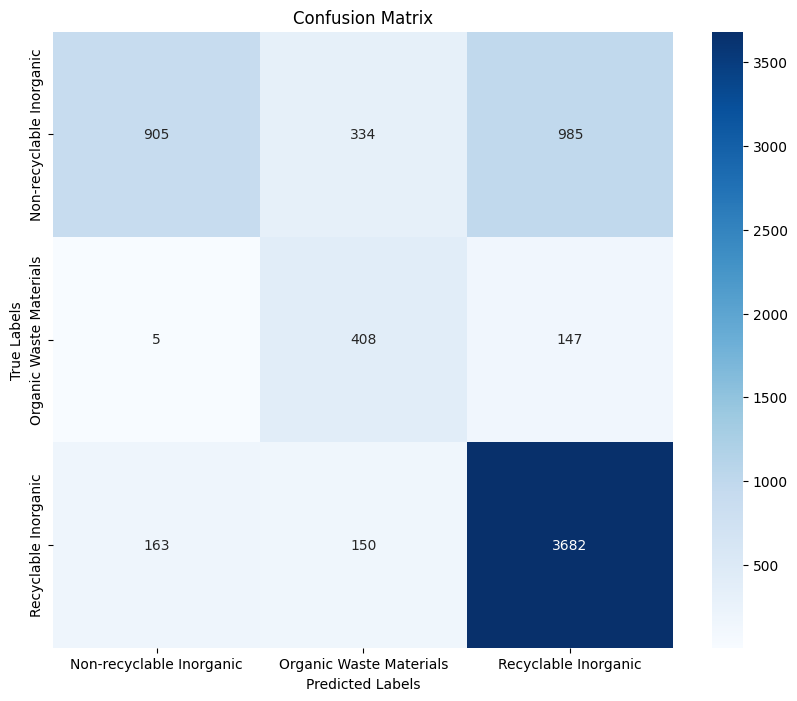

Accuracy: 0.74


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure validation_generator is properly defined
if 'validation_generator' not in globals():
    raise ValueError("The 'validation_generator' is not defined. Ensure it is initialized with your validation dataset.")

# Function to evaluate the model
def evaluate_model(generator, model):
    true_labels = generator.classes  # True labels from the generator
    class_names = list(generator.class_indices.keys())  # Class names

    # Get predictions
    predictions = model.predict(generator)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

    return true_labels, predicted_labels, class_names

# Evaluate the model and get metrics
true_labels, predicted_labels, class_names = evaluate_model(validation_generator, model)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate Accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")


1/1 [==============================] - 0s 199ms/step


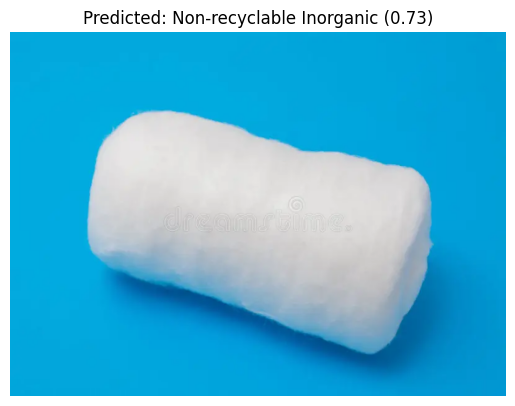

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to a single image for testing
image_path = 'Train/Non-recyclable Inorganic/Cotton/medical-cotton-blue-background-wool-abstract-136903144.jpg'  # Replace with the actual path to your test image

# Load and preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load the image with target size
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale the image
    return img_array

# Make a prediction
def predict_image(model, image_path, class_names):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)  # Predict probabilities
    predicted_class = np.argmax(predictions, axis=1)  # Get class index
    confidence = np.max(predictions)  # Get confidence score
    return predicted_class[0], confidence

# Class names (update these with your actual class names)
class_names = list(train_generator.class_indices.keys())

# Get prediction and confidence
predicted_class, confidence = predict_image(model, image_path, class_names)

# Display the image and the prediction
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f})")
plt.show()


In [5]:
# Save the model in H5 format
model.save("model.h5")
print("Model saved as final_robust_model.h5")


Model saved as final_robust_model.h5


In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops = True  # Enable TensorFlow ops
tflite_model = converter.convert()

# Save the model
with open("wasting.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted with TensorFlow Select Ops enabled.")


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp03pkg1nl\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp03pkg1nl\assets


Model converted with TensorFlow Select Ops enabled.


In [12]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D,
    BatchNormalization, Dropout, Concatenate, Add, LeakyReLU,
    SeparableConv2D, Activation, AveragePooling2D, Layer,
    GlobalMaxPooling2D, Reshape, Multiply
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, BackupAndRestore
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# For mixed precision training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

# Configuration
IMG_SIZE = 128  # Reduced for memory efficiency
BATCH_SIZE = 4  # Reduced for memory efficiency
NUM_CLASSES = 3
EPOCHS = 100
BASE_LR = 1e-4

# Define custom noise layer for training robustness
class GaussianNoiseLayer(Layer):
    def __init__(self, stddev=0.1):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev
        
    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), 
                                     mean=0.0, 
                                     stddev=self.stddev, 
                                     dtype=inputs.dtype)
            return inputs + noise
        return inputs
    
    def get_config(self):
        config = super().get_config()
        config.update({"stddev": self.stddev})
        return config

# Build custom inception-style module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, 
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0002))(x)
    
    # 3x3 convolution branch
    pre_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0002))(pre_3x3)
    
    # 5x5 convolution branch (using two 3x3 to reduce parameters)
    pre_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5_1 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu')(pre_5x5)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0002))(conv_5x5_1)
    
    # Pooling branch
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool)
    
    # Concatenate all branches
    output = Concatenate()([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

# Residual block with channel attention
def residual_block(x, filters, kernel_size=3, stride=1, use_attention=True):
    shortcut = x
    
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)
    
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    
    if use_attention:
        se = GlobalAveragePooling2D()(y)
        se = Dense(filters // 16, activation='relu')(se)
        se = Dense(filters, activation='sigmoid')(se)
        se = Reshape((-1, 1, 1, filters))(se)
        y = Multiply()([y, se])
    
    output = Add()([shortcut, y])
    output = LeakyReLU(0.2)(output)
    return output

# Create robust model architecture
def create_robust_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = GaussianNoiseLayer(stddev=0.05)(inputs)
    
    x = Conv2D(64, (7, 7), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = inception_module(x, 64, 48, 64, 16, 32, 32)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, use_attention=True)
    
    path1 = Conv2D(256, (3, 3), padding='same')(x)
    path1 = LeakyReLU(0.1)(path1)
    path1 = BatchNormalization()(path1)
    
    path2 = Conv2D(256, (3, 3), padding='same', dilation_rate=2)(x)
    path2 = LeakyReLU(0.1)(path2)
    path2 = BatchNormalization()(path2)
    
    path3 = SeparableConv2D(256, (5, 5), padding='same')(x)
    path3 = LeakyReLU(0.1)(path3)
    path3 = BatchNormalization()(path3)
    
    x = Concatenate()([path1, path2, path3])
    x = Conv2D(512, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=inputs, outputs=outputs)

# Enhanced data augmentation for robustness
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    validation_split=0.2
)

# Load data
train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    'Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Calculate class weights to handle imbalance
class_weights = None
try:
    total_samples = train_generator.samples
    class_counts = [0] * NUM_CLASSES
    for i in range(total_samples):
        class_counts[train_generator.labels[i]] += 1
    
    max_count = max(class_counts)
    class_weights = {i: float(max_count)/float(max(1, count)) for i, count in enumerate(class_counts)}
    print(f"Class weights: {class_weights}")
except Exception as e:
    print(f"Warning: Could not calculate class weights: {e}")

# Create and compile model
base_optimizer = Adam(learning_rate=BASE_LR)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)
model = create_robust_model()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1, min_delta=0.005),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    BackupAndRestore(backup_dir='./backup')
]

# Gradient accumulation training function with detailed metrics and manual checkpointing
def train_with_gradient_accumulation(model, train_generator, validation_generator, steps_per_epoch, validation_steps, epochs, callbacks):
    optimizer = model.optimizer
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    accum_steps = 4
    effective_batch_size = BATCH_SIZE * accum_steps
    best_val_acc = -float('inf')  # For manual checkpointing
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_iterator = iter(train_generator)
        val_iterator = iter(validation_generator)
        
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        total_train_loss = 0
        total_val_loss = 0
        
        for step in range(steps_per_epoch):
            gradients = [tf.zeros_like(var) for var in model.trainable_variables]
            step_train_loss = 0
            
            for _ in range(accum_steps):
                try:
                    x_batch, y_batch = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_generator)
                    x_batch, y_batch = next(train_iterator)
                
                with tf.GradientTape() as tape:
                    logits = model(x_batch, training=True)
                    loss = loss_fn(y_batch, logits)
                    scaled_loss = optimizer.get_scaled_loss(loss)
                
                scaled_grads = tape.gradient(scaled_loss, model.trainable_variables)
                grads = optimizer.get_unscaled_gradients(scaled_grads)
                gradients = [g + acc_g for g, acc_g in zip(grads, gradients)]
                step_train_loss += loss
                train_acc_metric.update_state(y_batch, logits)
            
            step_train_loss /= accum_steps
            gradients = [g / accum_steps for g in gradients]
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total_train_loss += step_train_loss
            
            if (step + 1) % 10 == 0 or step == steps_per_epoch - 1:
                print(f"Step {step + 1}/{steps_per_epoch}, "
                      f"Loss: {step_train_loss:.4f}, "
                      f"Accuracy: {train_acc_metric.result():.4f}")
        
        for val_step in range(validation_steps):
            try:
                x_val, y_val = next(val_iterator)
            except StopIteration:
                val_iterator = iter(validation_generator)
                x_val, y_val = next(val_iterator)
            
            val_logits = model(x_val, training=False)
            val_loss = loss_fn(y_val, val_logits)
            total_val_loss += val_loss
            val_acc_metric.update_state(y_val, val_logits)
        
        avg_train_loss = total_train_loss / steps_per_epoch
        avg_val_loss = total_val_loss / validation_steps
        train_acc = train_acc_metric.result()
        val_acc = val_acc_metric.result()
        
        print(f"Epoch {epoch + 1} Summary: "
              f"Training Loss: {avg_train_loss:.4f}, "
              f"Training Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model.save_weights('best_model.h5')
            print(f"Saved best model weights with validation accuracy: {val_acc:.4f}")
        
        logs = {
            'loss': float(avg_train_loss),
            'accuracy': float(train_acc),
            'val_loss': float(avg_val_loss),
            'val_accuracy': float(val_acc)
        }
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs=logs)

# Two-stage training with gradient accumulation
print("Stage 1: Feature extraction")
train_with_gradient_accumulation(
    model,
    train_generator,
    validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=50,  # First stage
    callbacks=callbacks
)

# Fine-tuning
print("Stage 2: Fine-tuning")
for layer in model.layers:
    layer.trainable = True

base_optimizer = Adam(learning_rate=BASE_LR/10)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_with_gradient_accumulation(
    model,
    train_generator,
    validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS-50,  # Second stage
    callbacks=callbacks
)

# Function for test-time augmentation (TTA)
def evaluate_with_tta(model, generator, num_tta=10):
    generator.reset()
    n_samples = generator.samples
    probabilities = np.zeros((n_samples, NUM_CLASSES))
    true_labels = np.zeros((n_samples, NUM_CLASSES))
    
    sample_count = 0
    true_labels_array = generator.classes
    true_labels = tf.keras.utils.to_categorical(true_labels_array, NUM_CLASSES)
    
    tta_datagen = ImageDataGenerator(
        preprocessing_function=lambda x: x/255.0,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    batch_size = generator.batch_size
    steps = int(np.ceil(n_samples / batch_size))
    
    for i in range(steps):
        x_batch, _ = next(generator)
        current_batch_size = x_batch.shape[0]
        
        batch_pred = model.predict(x_batch, verbose=0)
        batch_preds_all = batch_pred
        
        for j in range(num_tta - 1):
            x_aug = tta_datagen.flow(x_batch, batch_size=current_batch_size, shuffle=False).next()
            pred_aug = model.predict(x_aug, verbose=0)
            batch_preds_all = batch_preds_all + pred_aug
        
        batch_preds_all = batch_preds_all / num_tta
        
        end_idx = min(sample_count + current_batch_size, n_samples)
        probabilities[sample_count:end_idx] = batch_preds_all
        sample_count = end_idx
        
        if end_idx >= n_samples:
            break
    
    predicted_classes = np.argmax(probabilities, axis=1)
    true_classes = np.argmax(true_labels, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy, probabilities, true_labels

# Evaluate with TTA
# print("\nEvaluating with test-time augmentation...")
# tta_accuracy, predictions, true_labels = evaluate_with_tta(model, validation_generator)
# print(f"TTA Validation Accuracy: {tta_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Function to predict on new images with robustness
def predict_with_robustness(model, image_path, size=IMG_SIZE):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(size, size))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    
    augmentations = []
    augmentations.append(img_batch)
    augmentations.append(np.flip(img_batch, axis=2))
    
    from scipy.ndimage import rotate
    augmentations.append(np.expand_dims(rotate(img_array, angle=5, reshape=False), axis=0) / 255.0)
    augmentations.append(np.expand_dims(rotate(img_array, angle=-5, reshape=False), axis=0) / 255.0)
    
    all_preds = []
    for aug in augmentations:
        pred = model.predict(aug, verbose=0)
        all_preds.append(pred)
    
    avg_pred = np.mean(np.array(all_preds), axis=0)
    class_idx = np.argmax(avg_pred)
    probability = avg_pred[0][class_idx]
    return class_idx, probability

print("Training complete.")

ImportError: cannot import name 'layers' from partially initialized module 'keras' (most likely due to a circular import) (c:\Users\USER\anaconda3\envs\py39\lib\site-packages\keras\__init__.py)